In [1]:
library(lattice)
library(ggplot2)
library(GGally)
library(reshape2)
library(lme4)
library(compiler)
library(parallel)
library(boot)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2
Loading required package: Matrix

Attaching package: 'boot'

The following object is masked from 'package:lattice':

    melanoma



### Examples of mixed effects logistic regression

### Description of the data

In [2]:
hdp <- read.csv("./datasets/hdp.csv")
hdp <- within(hdp, {
          Married <- factor(Married, levels = 0:1, labels = c("no", "yes"))
          DID <- factor(DID)
          HID <- factor(HID)  })

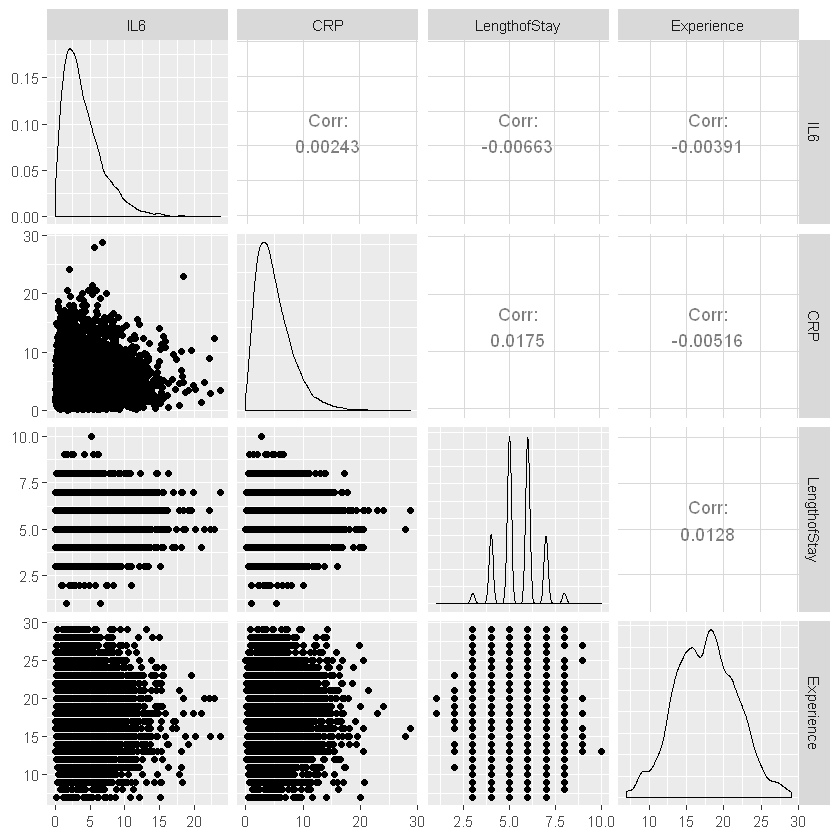

In [3]:
ggpairs(hdp[, c("IL6", "CRP", "LengthofStay", "Experience")])

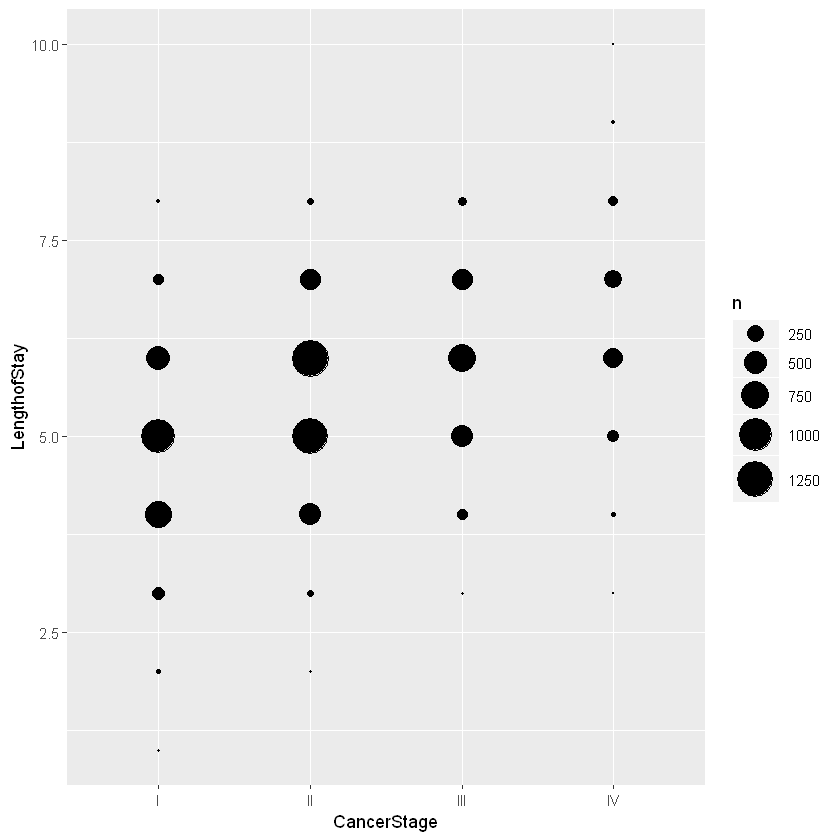

In [4]:
ggplot(hdp, aes(x = CancerStage, y = LengthofStay)) + 
    stat_sum(aes(size = ..n.., group = 1)) + scale_size_area(max_size=10)

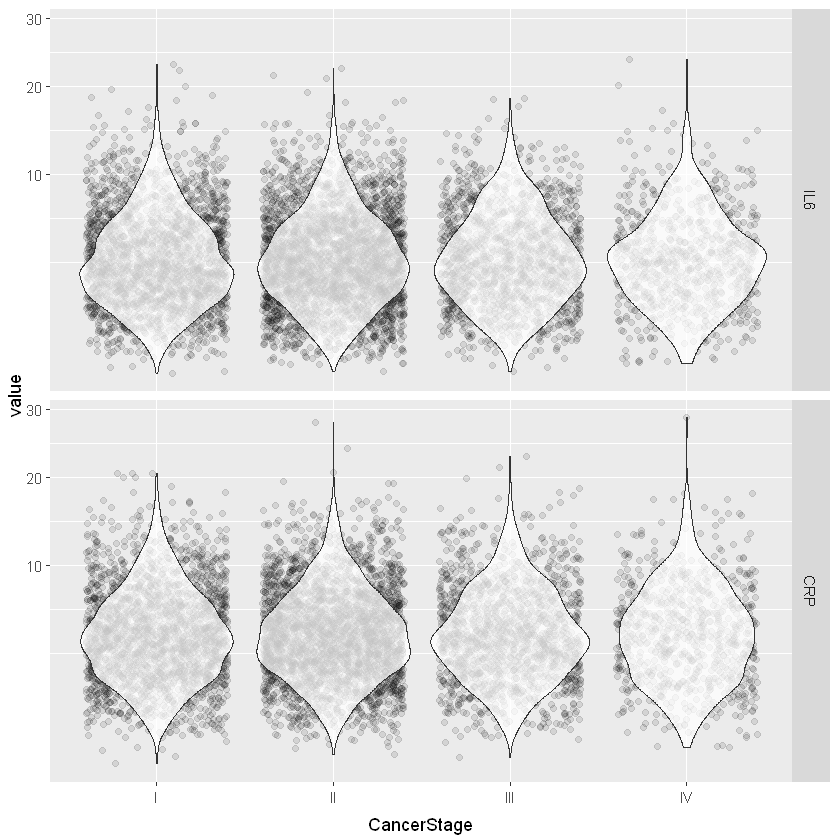

In [5]:
tmp <- melt(hdp[, c("CancerStage", "IL6", "CRP")], id.vars="CancerStage")

ggplot(tmp, aes(x = CancerStage, y = value)) + geom_jitter(alpha = .1) + geom_violin(alpha = .75) +
    facet_grid(variable ~ .) + scale_y_sqrt()

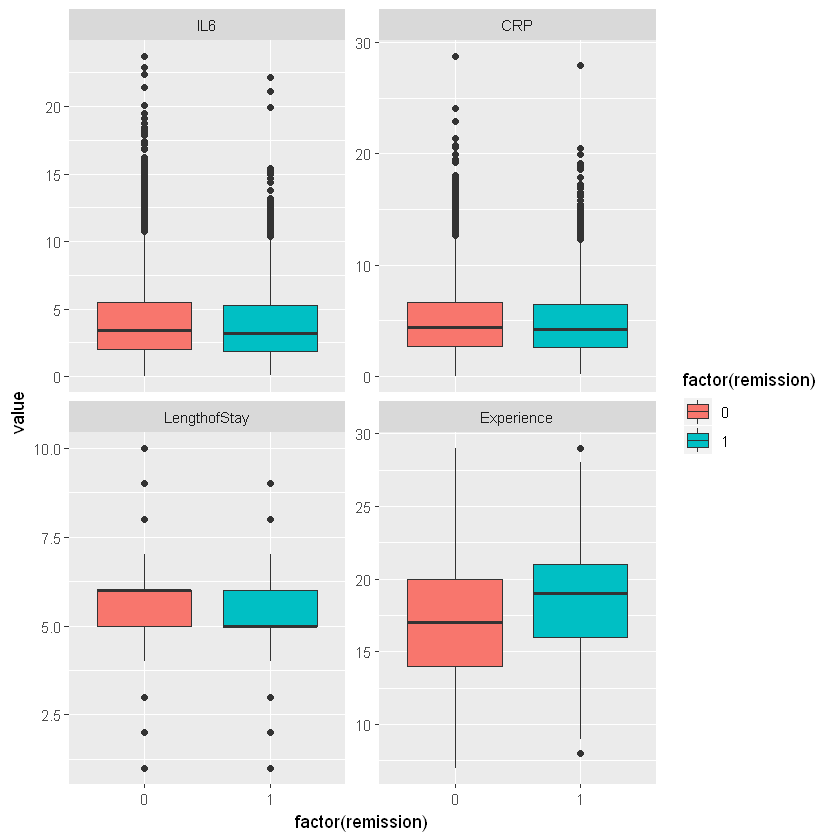

In [6]:
tmp <- melt(hdp[, c("remission", "IL6", "CRP", "LengthofStay", "Experience")], id.vars="remission")

ggplot(tmp, aes(factor(remission), y = value, fill=factor(remission))) +
    geom_boxplot() + facet_wrap(~variable, scales="free_y")

### Analysis methods you might consider

### Mixed effects logistic regression

In [7]:
# estimate the model and store results in m
m <- glmer(remission ~ IL6 + CRP + CancerStage + LengthofStay + Experience +
     (1 | DID), data = hdp, family = binomial, control = glmerControl(optimizer = "bobyqa"), nAGQ = 10)

# print the mod results without correlations among fixed effects
print(m, corr = FALSE)

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 10) [glmerMod]
 Family: binomial  ( logit )
Formula: remission ~ IL6 + CRP + CancerStage + LengthofStay + Experience +  
    (1 | DID)
   Data: hdp
      AIC       BIC    logLik  deviance  df.resid 
 7397.276  7460.733 -3689.638  7379.276      8516 
Random effects:
 Groups Name        Std.Dev.
 DID    (Intercept) 2.015   
Number of obs: 8525, groups:  DID, 407
Fixed Effects:
   (Intercept)             IL6             CRP   CancerStageII  CancerStageIII  
      -2.05272        -0.05677        -0.02148        -0.41393        -1.00346  
 CancerStageIV    LengthofStay      Experience  
      -2.33704        -0.12118         0.12009  


In [8]:
se <- sqrt(diag(vcov(m)))

# table of estimates with 95% CI
(tab <- cbind(Est = fixef(m), LL = fixef(m) - 1.96 * se, UL = fixef(m) + 1.96 * se))

,Est,LL,UL
(Intercept),-2.05272465,-3.09434931,-1.011099989
IL6,-0.05677182,-0.07934783,-0.034195814
CRP,-0.02148290,-0.04151096,-0.001454851
CancerStageII,-0.41393373,-0.56243109,-0.265436369
CancerStageIII,-1.00346445,-1.19609939,-0.810829506
CancerStageIV,-2.33703576,-2.64683096,-2.027240561
LengthofStay,-0.12118171,-0.18710305,-0.055260376
Experience,0.12008982,0.06628490,0.173894746


### Multilevel bootstrapping

In [9]:
sampler <- function(dat, clustervar, replace = TRUE, reps = 1) {
           cid <- unique(dat[, clustervar[1]])
           ncid <- length(cid)
           recid <- sample(cid, size = ncid * reps, replace = TRUE)
                    if (replace) {
                        rid <- lapply(seq_along(recid), function(i) {
                        cbind(NewID = i, RowID = sample(which(dat[, clustervar] == recid[i]),
                        size = length(which(dat[, clustervar] == recid[i])), replace = TRUE))
        })
    } else {
            rid <- lapply(seq_along(recid), function(i) {
                cbind(NewID = i, RowID = which(dat[, clustervar] == recid[i]))
        })
    }
    dat <- as.data.frame(do.call(rbind, rid))
    dat$Replicate <- factor(cut(dat$NewID, breaks = c(1, ncid * 1:reps), include.lowest = TRUE,
        labels = FALSE))
    dat$NewID <- factor(dat$NewID)
    return(dat)
    }

In [10]:
set.seed(20)
tmp <- sampler(hdp, "DID", reps = 100)
bigdata <- cbind(tmp, hdp[tmp$RowID, ])

In [11]:
f <- fixef(m)
r <- getME(m, "theta")
cl <- makeCluster(4)
clusterExport(cl, c("bigdata", "f", "r"))
clusterEvalQ(cl, require(lme4))

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

In [12]:
myboot <- function(i) {
          object <- try(glmer(remission ~ IL6 + CRP + CancerStage + LengthofStay +
                    Experience + (1 | NewID), data = bigdata, subset = Replicate == i, family = binomial,
                    nAGQ = 1, start = list(fixef = f, theta = r)), silent = TRUE)
          if (class(object) == "try-error")
            return(object)
              c(fixef(object), getME(object, "theta"))  }

In [13]:
start <- proc.time()
res <- parLapplyLB(cl, X = levels(bigdata$Replicate), fun = myboot)
end <- proc.time()

# shut down the cluster
stopCluster(cl)

In [14]:
# calculate proportion of models that successfully converged
success <- sapply(res, is.numeric)
mean(success)

[1] 1

Next we convert the list of bootstrap results into a matrix, and then calculate the 2.5th and 97.5th percentiles for each parameter. Finally, we can make a table of the results, including the original estimates and standard errors, the mean bootstrap estimate (which is asymptotically equivalent to the original results, but may be biased for a small number of replicates, as in our case), and the bootstrapped confidence intervals. With these data, you could also calculate bias-corrected bootstrap confidence intervals if you wanted, although we only show the percentile CIs.

In [15]:
# combine successful results
bigres <- do.call(cbind, res[success])

# calculate 2.5th and 97.5th percentiles for 95% CI
(ci <- t(apply(bigres, 1, quantile, probs = c(0.025, 0.975))))

,2.5%,97.5%
(Intercept),-3.72421211,-1.25688212
IL6,-0.09154637,-0.02471013
CRP,-0.04973428,0.01094456
CancerStageII,-0.61861153,-0.23534652
CancerStageIII,-1.39061739,-0.80566823
CancerStageIV,-2.78302671,-1.94368074
LengthofStay,-0.23423536,-0.03079553
Experience,0.09135308,0.19492490
NewID.(Intercept),2.08374164,2.51024334


In [16]:
# All results
finaltable <- cbind(Est = c(f, r), SE = c(se, NA), BootMean = rowMeans(bigres), ci)

# round and print
round(finaltable, 3)

,Est,SE,BootMean,2.5%,97.5%
(Intercept),-2.053,0.531,-2.472,-3.724,-1.257
IL6,-0.057,0.012,-0.060,-0.092,-0.025
CRP,-0.021,0.010,-0.023,-0.050,0.011
CancerStageII,-0.414,0.076,-0.421,-0.619,-0.235
CancerStageIII,-1.003,0.098,-1.062,-1.391,-0.806
CancerStageIV,-2.337,0.158,-2.448,-2.783,-1.944
LengthofStay,-0.121,0.034,-0.133,-0.234,-0.031
Experience,0.120,0.027,0.140,0.091,0.195
DID.(Intercept),2.015,NA,2.281,2.084,2.510


### Predicted probabilities and graphing

In [17]:
# temporary data
tmpdat <- hdp[, c("IL6", "CRP", "CancerStage", "LengthofStay", "Experience", "DID")]

summary(hdp$LengthofStay)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.000   5.000   5.492   6.000  10.000 

In [18]:
jvalues <- with(hdp, seq(from = min(LengthofStay), to = max(LengthofStay), length.out = 100))

# calculate predicted probabilities and store in a list
pp <- lapply(jvalues, function(j) {
             tmpdat$LengthofStay <- j
             predict(m, newdata = tmpdat, type = "response")   })

In [19]:
# average marginal predicted probability across a few different Lengths of Stay
sapply(pp[c(1, 20, 40, 60, 80, 100)], mean)

## [1] 0.3652 0.3366 0.3075 0.2796 0.2530 0.2278
# get the means with lower and upper quartiles
plotdat <- t(sapply(pp, function(x) {c(M = mean(x), quantile(x, c(0.25, 0.75)))   }))

# add in LengthofStay values and convert to data frame
plotdat <- as.data.frame(cbind(plotdat, jvalues))

# better names and show the first few rows
colnames(plotdat) <- c("PredictedProbability", "Lower", "Upper", "LengthofStay") 

head(plotdat)

[1] 0.3652316 0.3366359 0.3075493 0.2796360 0.2530110 0.2277696

PredictedProbability,Lower,Upper,LengthofStay
0.3652316,0.08489851,0.6155634,1.000000
0.3637053,0.08404653,0.6129531,1.090909
0.3621812,0.08320233,0.6103363,1.181818
0.3606595,0.08236584,0.6077131,1.272727
0.3591400,0.08153702,0.6050837,1.363636
0.3576228,0.08071580,0.6024482,1.454545


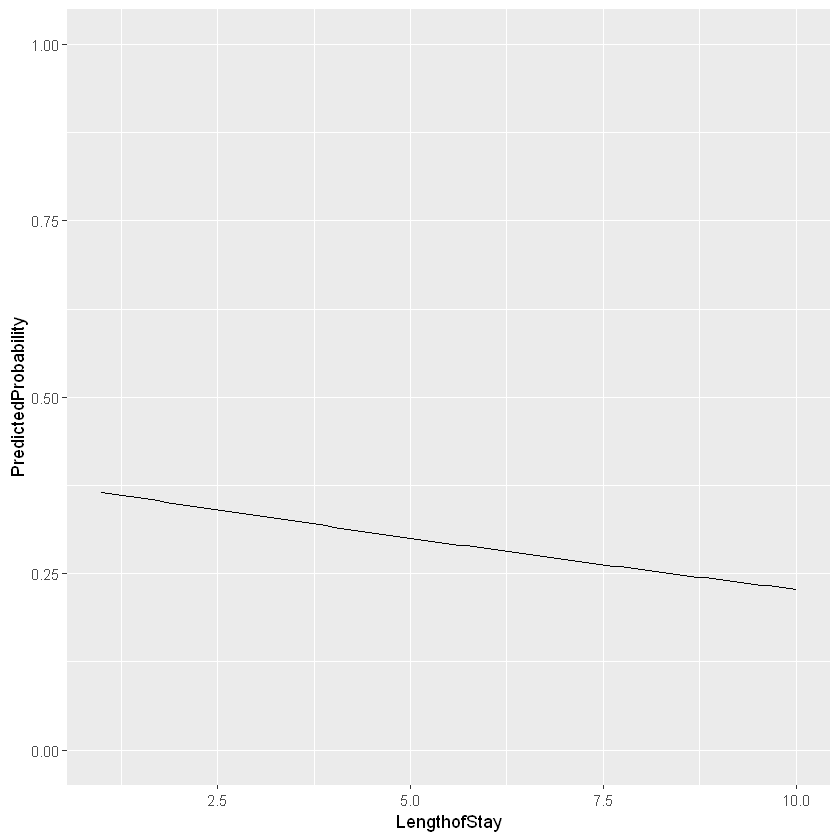

In [20]:
# plot average marginal predicted probabilities
ggplot(plotdat, aes(x = LengthofStay, y = PredictedProbability)) + geom_line() + ylim(c(0, 1))

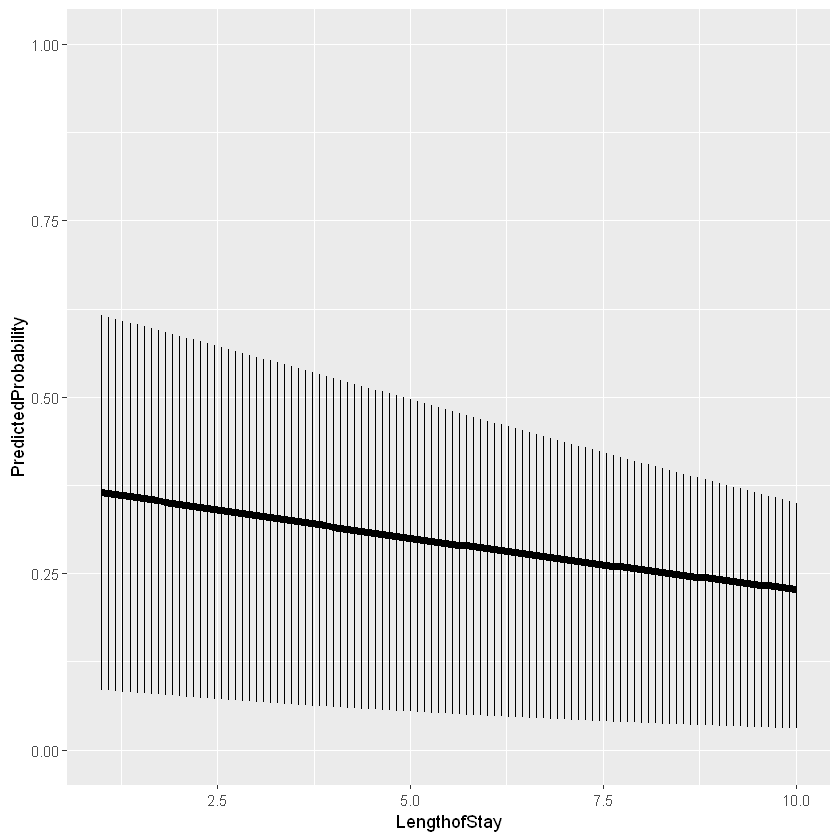

In [21]:
ggplot(plotdat, aes(x = LengthofStay, y = PredictedProbability)) + 
    geom_linerange(aes(ymin = Lower, ymax = Upper)) + geom_line(size = 2) + ylim(c(0, 1))

In [22]:
# calculate predicted probabilities and store in a list
biprobs <- lapply(levels(hdp$CancerStage), function(stage) {
                         tmpdat$CancerStage[] <- stage
           lapply(jvalues, function(j) {
                         tmpdat$LengthofStay <- j
           predict(m, newdata = tmpdat, type = "response")
                   })
           })

# get means and quartiles for all jvalues for each level of CancerStage
plotdat2 <- lapply(biprobs, function(X) {
            temp <- t(sapply(X, function(x) {
                    c(M=mean(x), quantile(x, c(.25, .75))) }))
            temp <- as.data.frame(cbind(temp, jvalues))
                    colnames(temp) <- c("PredictedProbability", "Lower", "Upper", "LengthofStay")
            return(temp)
           })

# collapse to one data frame
plotdat2 <- do.call(rbind, plotdat2)

# add cancer stage
plotdat2$CancerStage <- factor(rep(levels(hdp$CancerStage), each = length(jvalues)))

# show first few rows
head(plotdat2)

PredictedProbability,Lower,Upper,LengthofStay,CancerStage
0.4474659,0.1547403,0.7328356,1.000000,I
0.4457998,0.1533049,0.7306731,1.090909,I
0.4441349,0.1518804,0.7284997,1.181818,I
0.4424712,0.1504667,0.7263153,1.272727,I
0.4408088,0.1490639,0.7241199,1.363636,I
0.4391478,0.1476719,0.7219138,1.454545,I


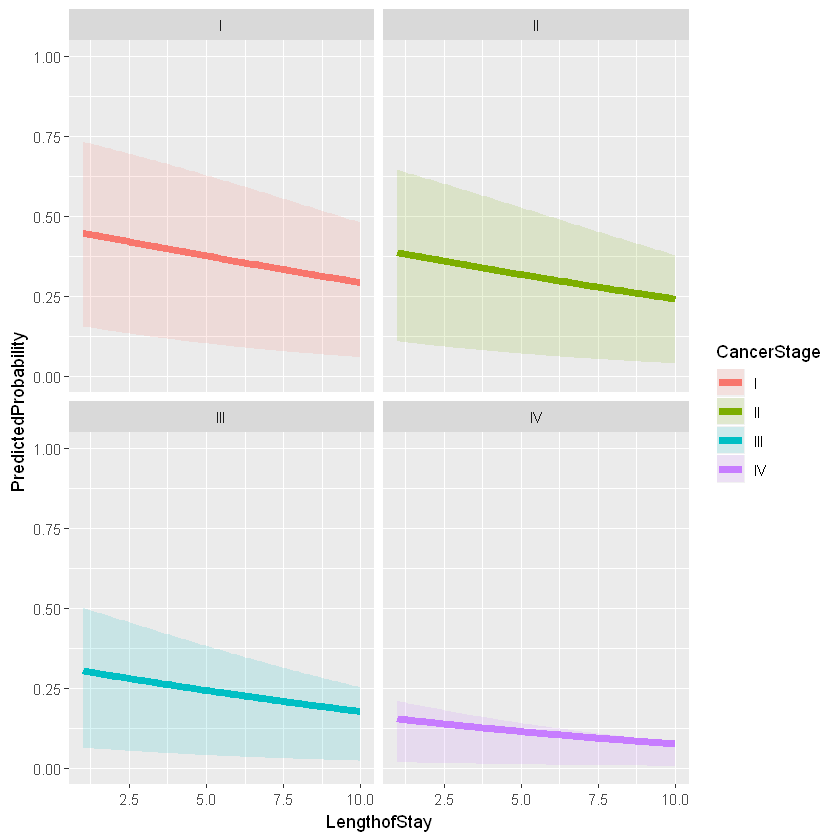

In [23]:
# graph it
ggplot(plotdat2, aes(x = LengthofStay, y = PredictedProbability)) +
    geom_ribbon(aes(ymin = Lower, ymax = Upper, fill = CancerStage), alpha = .15) + 
    geom_line(aes(colour = CancerStage), size = 2) + ylim(c(0, 1)) + facet_wrap(~  CancerStage)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


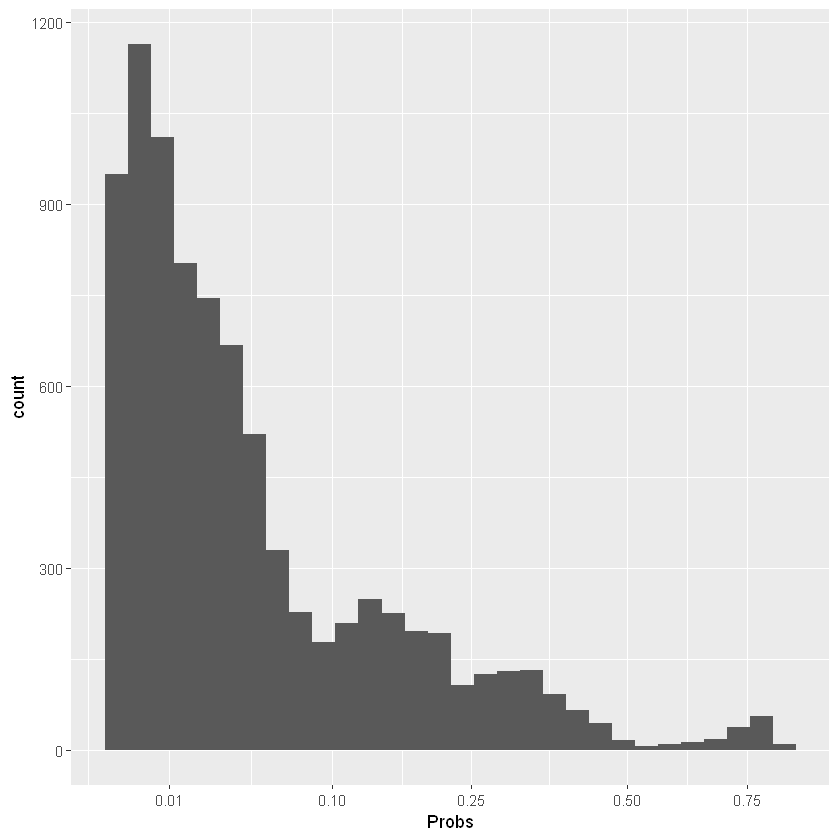

In [24]:
ggplot(data.frame(Probs = biprobs[[4]][[100]]), aes(Probs)) + geom_histogram() + 
    scale_x_sqrt(breaks = c(0.01, 0.1, 0.25, 0.5, 0.75))

### Three level mixed effects logistic regression

In [25]:
# estimate the model and store results in m
m3a <- glmer(remission ~ Age + LengthofStay + FamilyHx + IL6 + CRP +
       CancerStage + Experience + (1 | DID) + (1 | HID), data = hdp, family = binomial, nAGQ=1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.393623 (tol = 0.001, component 1)"

In [26]:
# print the mod results without correlations among fixed effects
print(m3a, corr=FALSE)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: remission ~ Age + LengthofStay + FamilyHx + IL6 + CRP + CancerStage +  
    Experience + (1 | DID) + (1 | HID)
   Data: hdp
      AIC       BIC    logLik  deviance  df.resid 
 7199.081  7283.690 -3587.541  7175.081      8513 
Random effects:
 Groups Name        Std.Dev.
 DID    (Intercept) 1.9513  
 HID    (Intercept) 0.5432  
Number of obs: 8525, groups:  DID, 407; HID, 35
Fixed Effects:
   (Intercept)             Age    LengthofStay     FamilyHxyes             IL6  
      -1.68309        -0.01496        -0.04576        -1.30787        -0.05729  
           CRP   CancerStageII  CancerStageIII   CancerStageIV      Experience  
      -0.02209        -0.31738        -0.85463        -2.13138         0.12703  
convergence code 0; 1 optimizer warnings; 0 lme4 warnings 


Warning message in ranef.merMod(m3a, which = "DID", postVar = TRUE):
"'postVar' is deprecated: please use 'condVar' instead"

$DID


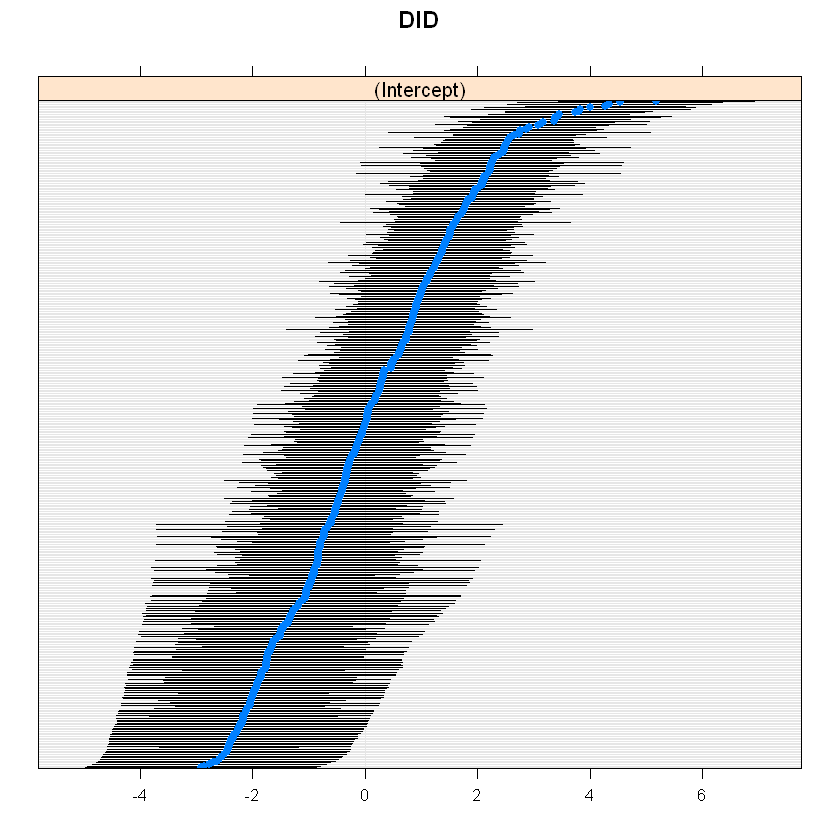

In [27]:
dotplot(ranef(m3a, which = "DID", postVar = TRUE), scales = list(y = list(alternating = 0)))

Warning message in ranef.merMod(m3a, which = "HID", postVar = TRUE):
"'postVar' is deprecated: please use 'condVar' instead"

$HID


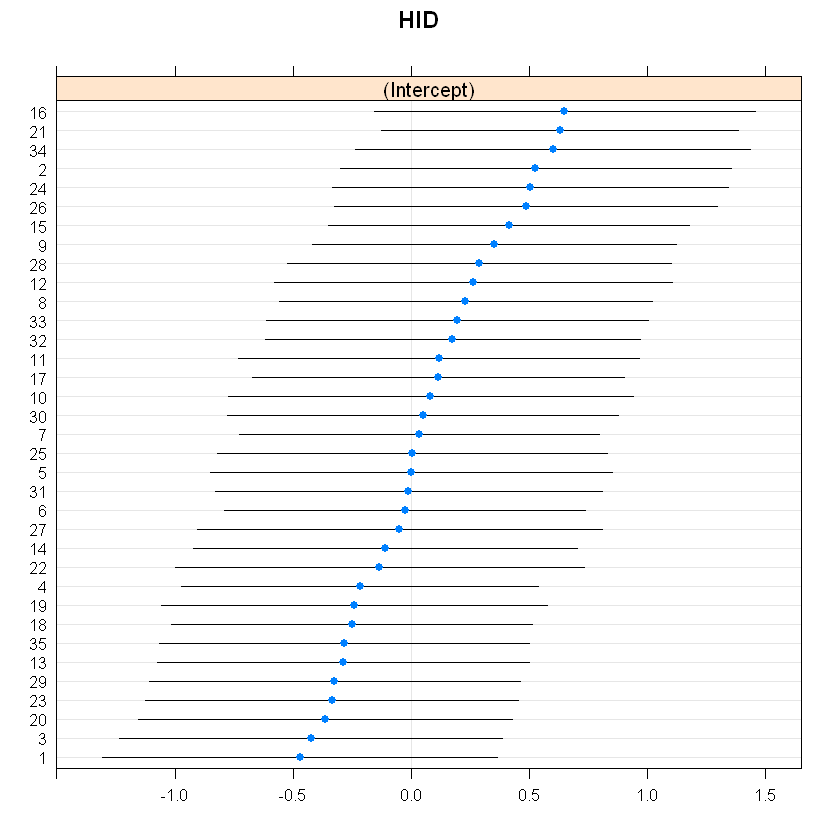

In [28]:
dotplot(ranef(m3a, which = "HID", postVar = TRUE))

In [29]:
# estimate the model and store results in m
m3b <- glmer(remission ~ Age + LengthofStay + FamilyHx + IL6 + CRP + CancerStage +
    Experience + (1 + LengthofStay | DID) + (1 | HID), data = hdp, family = binomial, nAGQ = 1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 1.58809 (tol = 0.001, component 1)"

In [30]:
# print the mod results without correlations among fixed effects
print(m3b, corr = FALSE)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: remission ~ Age + LengthofStay + FamilyHx + IL6 + CRP + CancerStage +  
    Experience + (1 + LengthofStay | DID) + (1 | HID)
   Data: hdp
      AIC       BIC    logLik  deviance  df.resid 
 7147.760  7246.471 -3559.880  7119.760      8511 
Random effects:
 Groups Name         Std.Dev. Corr 
 DID    (Intercept)  0.5065        
        LengthofStay 0.3715   -0.10
 HID    (Intercept)  0.7287        
Number of obs: 8525, groups:  DID, 407; HID, 35
Fixed Effects:
   (Intercept)             Age    LengthofStay     FamilyHxyes             IL6  
      -0.54512        -0.01530        -0.19020        -1.34032        -0.05852  
           CRP   CancerStageII  CancerStageIII   CancerStageIV      Experience  
      -0.02110        -0.29442        -0.86500        -2.29455         0.10460  
convergence code 0; 1 optimizer warnings; 0 lme4 warnings 


Warning message in ranef.merMod(m3b, which = "DID", postVar = TRUE):
"'postVar' is deprecated: please use 'condVar' instead"

$DID


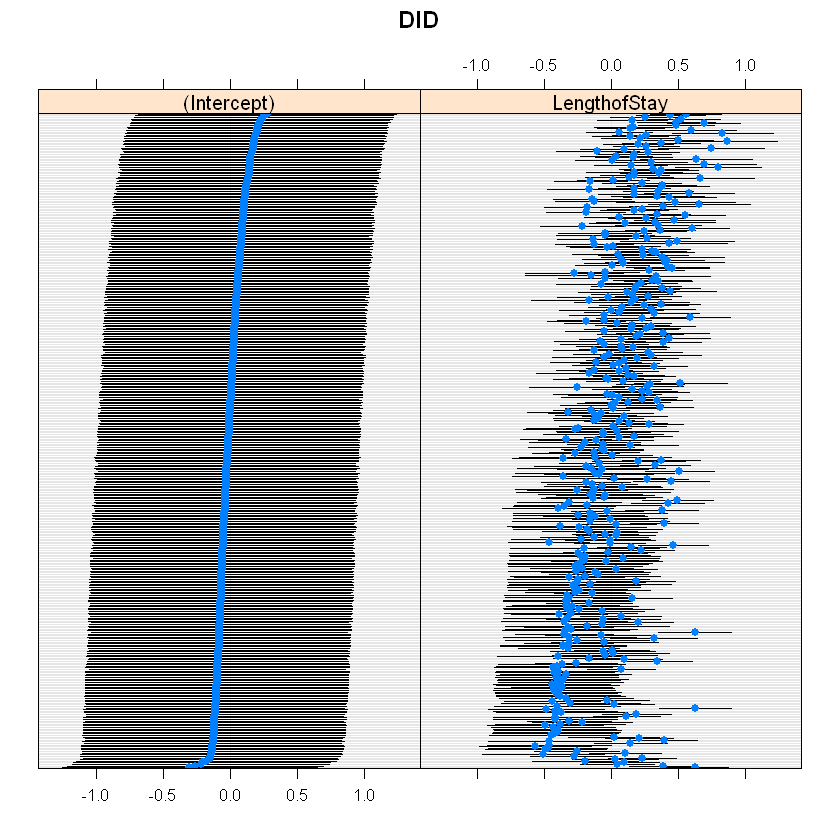

In [31]:
dotplot(ranef(m3b, which = "DID", postVar = TRUE), scales = list(y = list(alternating = 0)))

Warning message in ranef.merMod(m3b, which = "HID", postVar = TRUE):
"'postVar' is deprecated: please use 'condVar' instead"

$HID


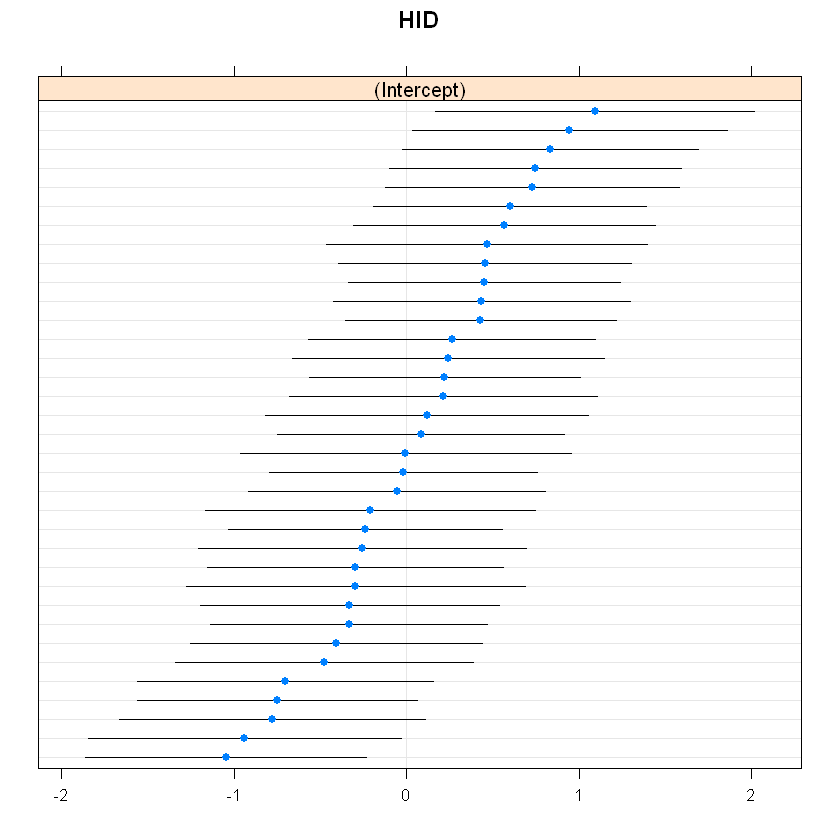

In [32]:
dotplot(ranef(m3b, which = "HID", postVar = TRUE), scales = list(y = list(alternating = 0)))